In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

** Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Install dependencies

In [23]:
from helper import plot_images, color_hist, bin_spatial, get_hog_features, extract_features
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
images = glob.glob('data/*/*/*.jpeg')
cars = []
not_cars = []
print(len(images))

2321


In [5]:
for image in images:
    if 'image' in image or 'extra' in image:
        not_cars.append(image)
    else:
        cars.append(image)
print(len(cars), len(not_cars))

1196 1125


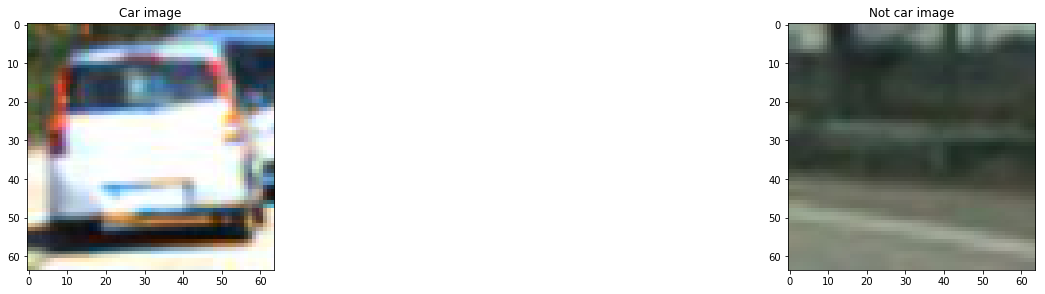

In [6]:
car_id = np.random.randint(0, len(cars))
not_car_id = np.random.randint(0, len(not_cars))

car_img = mpimg.imread(cars[car_id])
not_car_img = mpimg.imread(not_cars[not_car_id])

plot_images([car_img, not_car_img], ['Car image', 'Not car image'])

In [7]:
print(car_img.shape, not_car_img.shape)
print(car_img.dtype, not_car_img.dtype)

(64, 64, 3) (64, 64, 3)
uint8 uint8


## Explore vaious feature extraction

### Get histgram of color

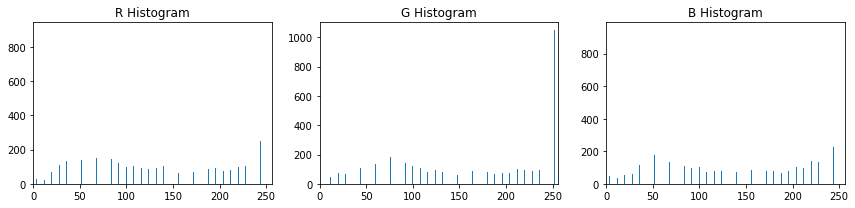

In [8]:
rh, gh, bh, bincen, feature_vec = color_hist(car_img, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

### Spatial benning of color

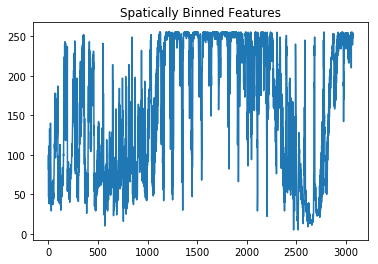

In [9]:
feature_vec = bin_spatial(car_img, color_space='RGB', size=(32, 32))
plt.plot(feature_vec)
plt.title('Spatically Binned Features')

### Hog features

In [10]:
gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
features, hog_img = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, visalise=True)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


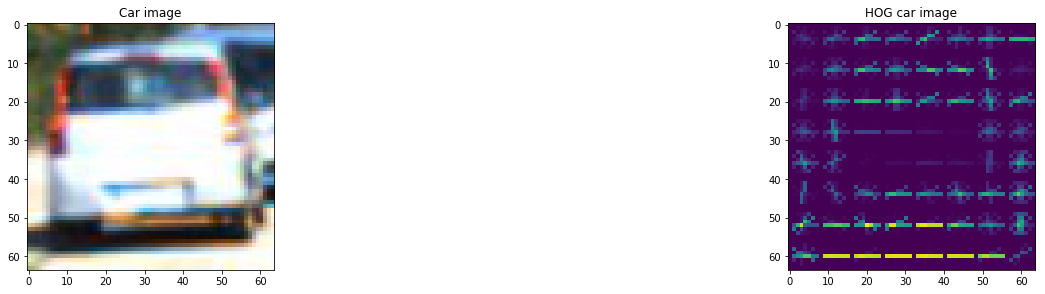

In [11]:
# Plot car original and hog image

plot_images([car_img, hog_img], ['Car image', 'HOG car image'])

## Combine and normalize features extracted by above methods

In [12]:
car_features = extract_features(cars, color_space='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0, 256))
not_car_features = extract_features(not_cars, color_space='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0, 256))

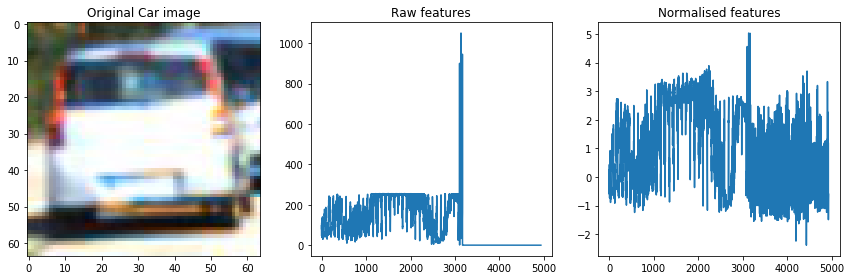

In [13]:
if len(car_features) > 0:
    X = np.concatenate((car_features, not_car_features))
    # X = np.vstack((car_features, not_car_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(car_img)
    plt.title('Original Car image')
    plt.subplot(132)
    plt.plot(X[car_id])
    plt.title('Raw features')
    plt.subplot(133)
    plt.plot(scaled_X[car_id])
    plt.title('Normalised features')
    fig.tight_layout()
else:
    print('Empty feature vectors')

In [14]:
# Create an array stack of feature vectors
X = np.concatenate((car_features, not_car_features))
# Define label vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

In [24]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [25]:
# Fit a per-column scaler only on the training set
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


In [26]:
# Use a linear SVC
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Secods to train SR')

0.77 Secods to train SR


In [27]:
print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC:  0.9842


In [28]:
t=time.time()
n_predict=10
print('My svc predicts: ', svc.predict(X_test[0: n_predict]))
print('actual labels: ', y_test[0: n_predict])
t2=time.time()
print(round(t2-t, 2), 'Secods to predict svc')

My svc predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
actual labels:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
0.01 Secods to predict svc


In [29]:
# Use random forest
random_forest = RandomForestClassifier(min_samples_leaf=20)
t = time.time()
random_forest.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Secods to train random forest')
print('Test Accuracy of Random Forest: ', round(random_forest.score(X_test, y_test), 4))

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
0.35 Secods to train random forest
Test Accuracy of Random Forest:  0.9713


In [30]:
n_predict=10
t=time.time()
print('My forest predicts: ', random_forest.predict(X_test[0: n_predict]))
print('actual labels: ', y_test[0: n_predict])
t2=time.time()
print(round(t2-t, 2), 'Secods to predict random forest')

My forest predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
actual labels:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
0.01 Secods to predict random forest
